# Calibration curve - heart data

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Functions
def plot_reliability_curves(pred_probs_midpoints, empirical_probs, calibrated_probs, calibrated=False):
    # Chart settings
    figsize = (8, 4)
    title_fontsize = 16
    label_fontsize = 12
    legend_fontsize = 12

    # Set up chart figure
    plt.figure(figsize=figsize)
    plt.title(f"{model_str} reliability curve",
              fontsize=title_fontsize)
    plt.xlabel('predicted prob',
               fontsize=label_fontsize)
    plt.ylabel('empirical prob',
               fontsize=label_fontsize)

    # Plots
    plt.plot(pred_probs_midpoints,
             empirical_probs,
             linewidth=2,
             marker='o')

    plt.plot([0,1],
             [0,1],
             linestyle='--',
             color='gray')
    
    if calibrated:
        plt.plot([0.0]+pred_probs_midpoints+[1.0],
                calibrated_probs,
                linewidth=2,
                marker='o')
        plt.legend(['original', 'ideal', 'calibrated'], fontsize=legend_fontsize)
    else:
        plt.legend(['original', 'ideal'], fontsize=legend_fontsize)


def update_probabilities(pred_prob_dict, test_sample, valid_sample, calibrated=False):
    # Train calibration_model
    lr_model = LogisticRegression()
    lr_model.fit(pred_prob_dict['test'].reshape(-1,1), test_sample)

    # Initialize probabilities
    empirical_probs = []
    pred_probs_midpoints = []

    # Calibrate on validation set otherwise use test set
    if calibrated:
        data_sample = valid_sample
        pred_probs = pred_prob_dict['valid']
    else:
        data_sample = test_sample
        pred_probs = pred_prob_dict['test']
    
    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(data_sample[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    if calibrated:
        calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
    else:
        calibrated_probs = np.empty([1, 1])
    return pred_probs_midpoints, empirical_probs, calibrated_probs, lr_model

### Load data

In [3]:
# Load heart disease data
df = pd.read_csv('heart.csv')

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

columns_keep = ['target', 'exang', 'cp', 'oldpeak', 'thalach', 'ca', 'slope', 'thal', 'sex', 'age', 'trestbps', 'restecg']
df = df[columns_keep]
df.head()

,target,exang,cp,oldpeak,thalach,ca,slope,thal,sex,age,trestbps,restecg
0,1,0,2,2.0,168,0,1,2,1,41,130,0
1,0,1,0,0.0,136,0,1,2,0,63,124,1
2,0,1,0,0.0,156,0,2,3,1,35,126,0
3,1,0,0,0.6,122,0,1,2,0,42,102,0
4,1,0,1,0.0,179,2,2,2,0,63,140,1


#### Train-test split

In [4]:
train_frac = 0.33
test_frac = 0.33

train_X = df[[c for c in df.columns if c != 'target']].iloc[:int(len(df) * train_frac)].values
train_y = df.target.iloc[:int(len(df) * train_frac)].values

test_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * train_frac):int(len(df) * (train_frac + test_frac))].values
test_y = df.target.iloc[int(len(df) * train_frac):int(len(df) * (train_frac + test_frac))].values

valid_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * (train_frac + test_frac)):].values
valid_y = df.target.iloc[int(len(df) * (train_frac + test_frac)):].values

### Train models and get probabilities

In [5]:
model_to_clf = {
    'rf': RandomForestClassifier,
    'svc': SVC,
    'nb': GaussianNB}

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.naive_bayes.GaussianNB'>


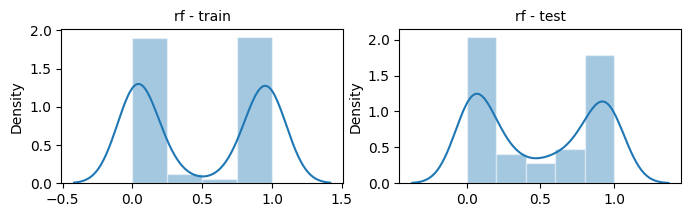

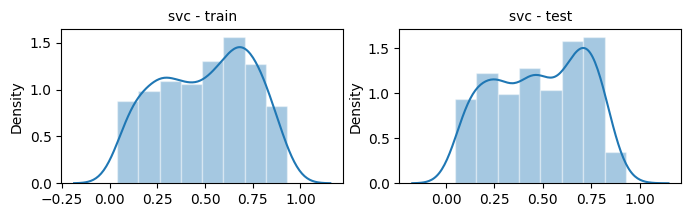

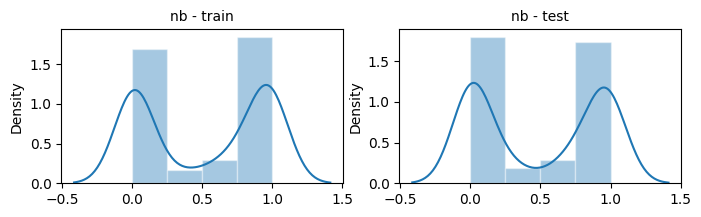

In [6]:
model_to_probs = {}
model_str_to_trained_model = {}

for model_str, model in model_to_clf.items():
    print(model)
    if model == SVC:
        clf = model(probability=True)
    elif model == LogisticRegression:
        clf = model(solver='liblinear')
    else:
        clf = model()
        
    clf.fit(train_X, train_y)
    
    pred_probs_train = clf.predict_proba(train_X)[:,1]
    pred_probs_test = clf.predict_proba(test_X)[:,1]
    pred_probs_valid = clf.predict_proba(valid_X)[:,1]
    
    model_to_probs[model_str] = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}
    
    plt.figure(figsize=(8, 2))
    
    plt.subplot(1, 2, 1)
    sns.histplot(pred_probs_train,
                 bins='fd',
                 stat='density',
                 kde=True,
                 kde_kws=dict(cut=3),
                 alpha=.4,
                 edgecolor=(1, 1, 1, .4))
    plt.title(f"{model_str} - train", fontsize=10)
    
    plt.subplot(1, 2, 2)
    sns.histplot(pred_probs_test,
                 bins='fd',
                 stat='density',
                 kde=True,
                 kde_kws=dict(cut=3),
                 alpha=.4,
                 edgecolor=(1, 1, 1, .4))
    plt.title(f"{model_str} - test", fontsize=10)
    
    model_str_to_trained_model[model_str] = clf
plt.show()

### Plot predicted probabilities vs. empirical probabilities

Reliability curves:
* Random Forest - not following the ideal line. It under- and over-predicts.
* Support Vector Machine - more closely aligned to the ideal line. Lacks coverage for 0 to 0.2 and 0.8 to 1.0.
* Naive Bayes - does not follow the ideal line. It under- and over-predicts.

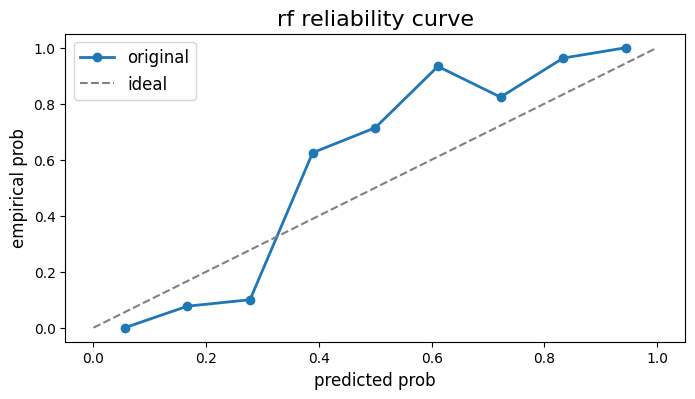

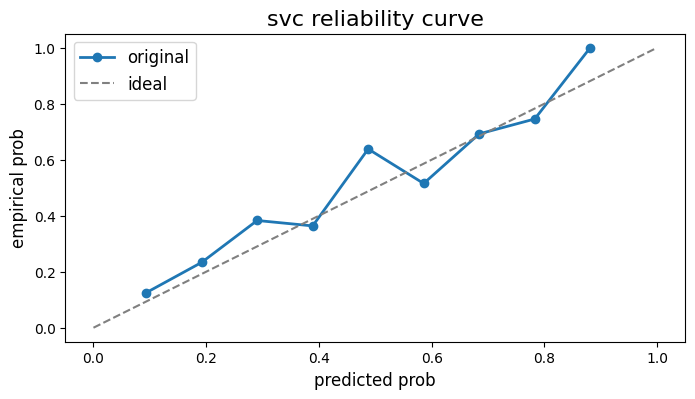

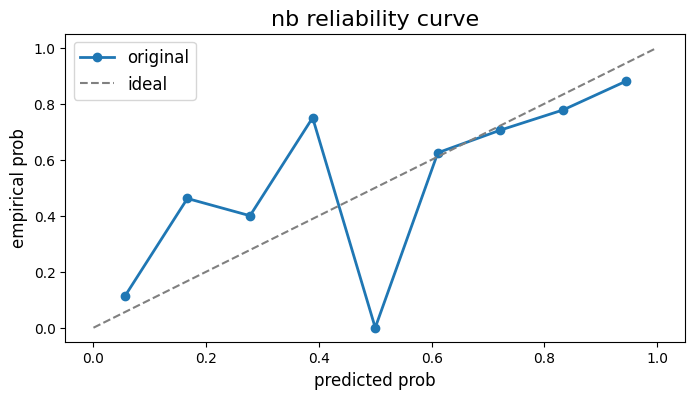

In [7]:
# Uncalibrated models
for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs_midpoints, empirical_probs, calibrated_probs, lr_model = update_probabilities(pred_prob_dict, test_sample=test_y, valid_sample=valid_y, calibrated=False)
    plot_reliability_curves(pred_probs_midpoints, empirical_probs, calibrated_probs, calibrated=False)

### Calibrate the models

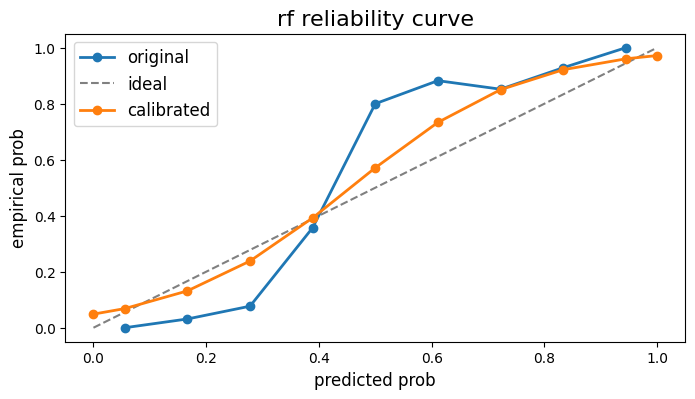

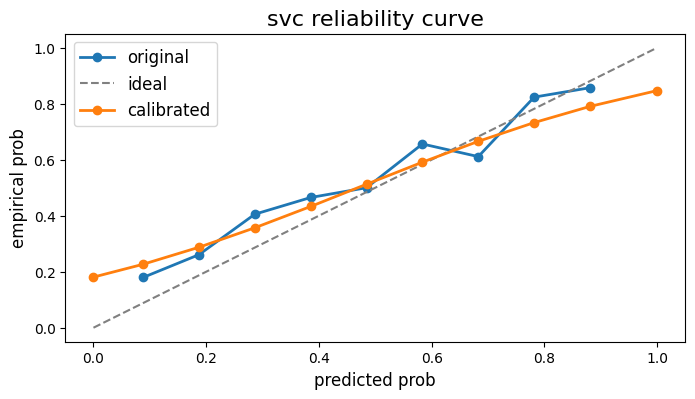

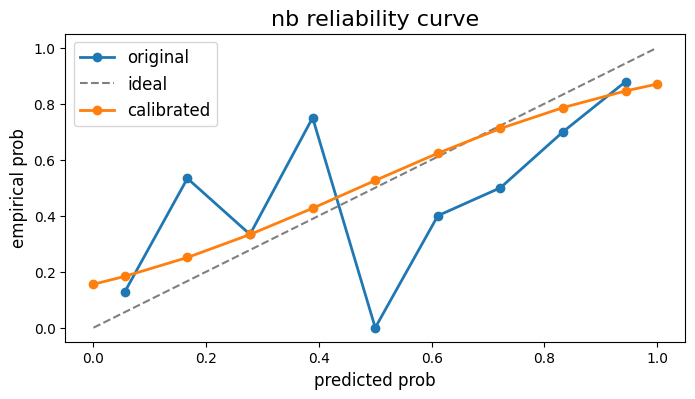

In [8]:
# Calibrated models
model_str_to_calibrator = {}

for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs_midpoints, empirical_probs, calibrated_probs, lr_model = update_probabilities(pred_prob_dict, test_sample=test_y, valid_sample=valid_y, calibrated=True)
    plot_reliability_curves(pred_probs_midpoints, empirical_probs, calibrated_probs, calibrated=True)
    model_str_to_calibrator[model_str] = lr_model

### Get calibrated predicted probability on new data point

In [9]:
# Base model - we chose Random Forest
clf = model_str_to_trained_model['rf']

# Get calibration layer
lr = model_str_to_calibrator['rf']

# New data point
new_sample = np.array([[1, 0, 0.6, 110, 1, 0, 0, 1, 85, 170, 0]])

In [10]:
# Calculate uncalibrated and calibrated probabilities
uncal_prob = clf.predict_proba(new_sample)[:,1][0]
cal_prob = lr.predict_proba(np.array([[uncal_prob]]))[:,1][0]

print(f"Uncalibrated probability (person having a heart attack) = {100 * uncal_prob:.1f} %")
print(f"Calibrated probability (person having a heart attack) = {100 * cal_prob:.1f} %")

Uncalibrated probability (person having a heart attack) = 26.0 %
Calibrated probability (person having a heart attack) = 21.8 %
